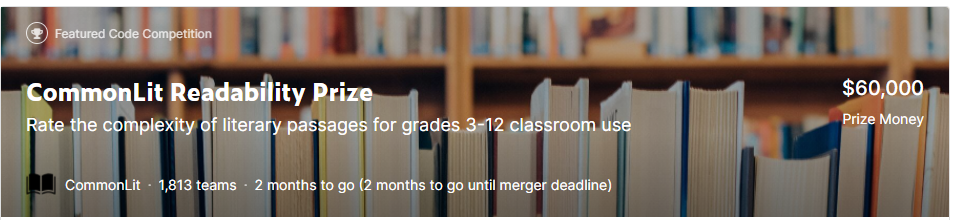



このコンペで重要なのは、”3 年生から 12 年生の教室で使用する文節の複雑さを評価する”ことだそうです。<br>
今のちからではどうすればいいのかわかりませんが。

# ディスカッションメモ　ほぼ謎
・現在、ほとんどの教育テキストは、従来の読みやすさの方法または市販の公式を使用して読者と照合されています。 ただし、それぞれに問題があります。 Flesch-Kincaid Grade Levelのようなツールは、テキストデコードの弱いプロキシ（つまり、単語ごとの文字または音節）と構文の複雑さ（つまり、文ごとの数または単語）に基づいています。 結果として、それらは構成概念と理論的妥当性を欠いています。 同時に、Lexileなどの市販の数式は、コストが高く、適切な検証研究が不足しており、数式の機能が公開されていない場合は透明性の問題に悩まされる可能性があります。<br>
・参加者はまた、2つのテキストのどちらが理解しやすいか（つまり、理解）、2つのテキストのどちらがより速く読んだか（つまり、参加者がテキストを読むのにどれだけの処理努力を費やしたと感じたか）を選択するように求められました。 彼らがよりよく知っていた2つのテキストのうち。 最初の2つの比較は、その後の読みやすさの分析で使用されるデータを形成しました。<br>
・読みやすさのスコアとは何ですか？素晴らしい質問です！ 読みやすさのスコアは、誰かが特定のテキストを読むのがどれほど簡単かを示す数値です。<br>
・「他の多くのノートブックには、活用できる優れたアプローチがあります。投票数とフォーク数が少ないのに役立つコードもありますが、役立つアイデアもあります。現在考えているものとは異なる方法で考えるのに役立つコードもありますか？」<br>
・堅牢な検証セットの構築に焦点を当てる：重要性をこれ以上強調することはできません。 多くの場合に発生するシェイクアップと戦うために、堅牢な検証セットが必要です。 最良の方法は、競技の早い段階でフォールドを生成し、それらをデータセットとして使用することです。<br>
・AutoNLPは、Hugging Faceの新しい（有料）サービスであり、特定のデータセットで数百のモデルをトレーニングできます。 したがって、インフラストラクチャ、モデルの選択、微調整、ハイパーパラメータの最適化（または展開）について心配する必要はありません。 AutoNLPのリポジトリをここでチェックしてください：https：//github.com/huggingface/autonlp<br>
・AutoMLがここでどのように機能しているかを完全に把握することはまだできません。 ノートブックの構成ファイルからわかる限り、RobertaForSequenceClassificationを使用しており、サイズは、すべてのデフォルト構成を備えたRoberta-Baseであることを示しています。 しかし、同じことを手動で行うと、5倍または6倍の同じモデルで0.52 + rmseを超えています。 それで、私の場合により有望であるが、あなたのスコアにはほど遠いので、私はDeBERTaベースに切り替えました。<br>
・BERTは、今日さまざまなNLPタスクを解決するために広く使用されている最もホットなモデルアーキテクチャの1つです。 したがって、このモデルについての深い知識を得ることが非常に重要です。 BERTには、いくつかのブログ、チュートリアルなどがあります。 しかし、完全なモデルを理解するための完全なパッケージを見つけることは非常にまれです。<br>
・この競争は一見簡単に思えるかもしれませんが、それだけではありません。私の修士課程では、人間によって作成および評価されたデータのいくつかの側面を研究しました。これは通常、主観的な方法で収集された情報です。<br>
・競争は厳しいですが、あなたが言及した理由のためではありません。 ラベルは確かに騒々しいですが、あなたのモデルはとにかく最良の中間点を見つけるのにかなり優れています、そしてそれから問題外のアンサンブルにそれらの数十があります。理由は次のとおりです。問題とメトリクスの両方が単純すぎて、データを任意のハグフェイスモデルに入力するだけで、すでに適切な結果が得られます。巧妙なモデリングや後処理は必要なく、可能性もありません。
これは、機能エンジニアリングの必要性につながります。 これは興味深い部分です。
どのような機能が必要ですか？ それはあなたの平均的なトランスフォーマーがそれ自体で理解していないものであるに違いありません、そして私たちはトランスフォーマーが何を知っているのか本当に知りません。 したがって、突破口を開くには、一歩下がってブラックボックスをさらに調べ、ブラックボックスに何が含まれていないかを確認する必要があります。それが勝つ方法です。

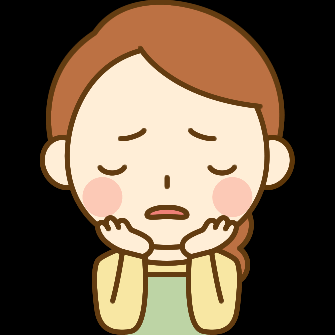

## Dependencies

In [ ]:
import random, os, warnings, math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from transformers import TFAutoModelForSequenceClassification, TFAutoModel, AutoTokenizer


def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 150)

### Hardware configuration

In [ ]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

# Load data

この目的関数のtargetがなんのことか全くわからない。standard_errorも。

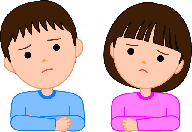

In [ ]:
train_filepath = '/kaggle/input/commonlitreadabilityprize/train.csv'
test_filepath = '/kaggle/input/commonlitreadabilityprize/test.csv'

train = pd.read_csv(train_filepath)
test = pd.read_csv(test_filepath)

print(f'Train samples: {len(train)}')
display(train.head())

print(f'Test samples: {len(test)}')
display(test.head())

# removing unused columns
train.drop(['url_legal', 'license'], axis=1, inplace=True)
test.drop(['url_legal', 'license'], axis=1, inplace=True)

# Model parameters

In [ ]:
BATCH_SIZE = 8 * REPLICAS
LEARNING_RATE = 1e-5 * REPLICAS
EPOCHS = 35
ES_PATIENCE = 7
PATIENCE = 2
N_FOLDS = 6
SEQ_LEN = 256 #300
BASE_MODEL = '/kaggle/input/huggingface-roberta/roberta-base/' #bertモデル

## 補助機能

In [ ]:
# Datasets utility functions
def custom_standardization(text): #@01
    text = text.lower() # if encoder is uncased
    text = text.strip()
    return text


def sample_target(features, target):
    mean, stddev = target
    sampled_target = tf.random.normal([], mean=tf.cast(mean, dtype=tf.float32), 
                                      stddev=tf.cast(stddev, dtype=tf.float32), dtype=tf.float32)
    
    return (features, sampled_target)
    

def get_dataset(pandas_df, tokenizer, labeled=True, ordered=False, repeated=False,  #train中に呼ばれる。
                is_sampled=False, batch_size=32, seq_len=128):
    """
       トレーニングまたは推論の準備ができているTensorflowデータセットを返します。
    """
    text = [custom_standardization(text) for text in pandas_df['excerpt']] #@01
    
    # Tokenize inputs
    tokenized_inputs = tokenizer(text, max_length=seq_len, truncation=True, 
                                 padding='max_length', return_tensors='tf')
    
    if labeled:
        dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': tokenized_inputs['input_ids'], 
                                                      'attention_mask': tokenized_inputs['attention_mask']}, 
                                                      (pandas_df['target'], pandas_df['standard_error'])))
        if is_sampled:
            dataset = dataset.map(sample_target, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = tf.data.Dataset.from_tensor_slices({'input_ids': tokenized_inputs['input_ids'], 
                                                      'attention_mask': tokenized_inputs['attention_mask']})
        
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(1024)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset


def plot_metrics(history):
    metric_list = list(history.keys())
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 5))
    axes = axes.flatten()
    
    for index in range(len(metric_list)//2):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+size]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric_name)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

# EDA

### 少しサンプルをみてみる

何がどうなるとこの数字になるのか。。。

In [ ]:
display(train.head())

### 次に、5 つの最も低い「ターゲット」値の例

In [ ]:
display(train.sort_values(by=['target']).head())

### 5 つの最も高い「ターゲット」値の例

In [ ]:
display(train.sort_values(by=['target'], ascending=False).head())

”これらのサンプルを見るだけでは、それらの「ターゲット」スコアを判断するのは少し難しいかもしれません。「ターゲット」スコアが最も低いサンプルには、文法、セマンティクス、句読点のエラーが混在しているようです。 読んだり理解したりするのを難しくします。”とのことですが、うーん、そうかなあ。日本人にはよくわからない。

## ラベルの配布

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(train['target'], ax=ax)
plt.show()

「ターゲット」列は正規分布に従いますが、正のスコアよりも負のスコアのサンプルがはるかに多いです。負の値は「-4」に近づき、正の値は「2」までしか上昇しません。 でも、なにを意味するのか。

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(train['standard_error'], ax=ax)
plt.show()

”「standard_error」列には、「0.4」よりも低い値の外れ値がいくつかあるようです。”とありますが、外れ値なのかなあ。 

In [ ]:
print(f"standard_error values >= than 0.4: {len(train[train['standard_error'] >= 0.4])}")
print(f"standard_error values < than 0.4: {len(train[train['standard_error'] < 0.4])}")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x=train['target'], y=train['standard_error'], s=10, color=".15")
sns.kdeplot(x=train['target'], y=train['standard_error'], levels=5, color="r", linewidths=1)
plt.ylim([0.4, None])
plt.show()

targetとstandard_errorの相関関係。極端な「ターゲット」値（「-4」と「2」に近い）を持つサンプルは、standard_errorの値が高くなっている。<br>
で、どうしろと？

##  `テキスト配布

### `長さ

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL) #@02
#エンコーダーはAutoTokenizer.from_pretrained()で呼び出せます。bert-base-japaneseはWikipediaの日本語版で事前学習済みのサブワード辞書となります
#英語なのでroberta-baseをつかっている

train['excerpt_len'] = train['excerpt'].apply(lambda x : len(x))
train['excerpt_wordCnt'] = train['excerpt'].apply(lambda x : len(x.split(' ')))
train['excerpt_tokenCnt'] = train['excerpt'].apply(lambda x : len(tokenizer.encode(x, add_special_tokens=False)))

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(train['excerpt_len'], ax=ax).set_title('Excerpt length')
plt.show()

In [ ]:
train['excerpt_wordCnt'] #空白で区切ってみた場合の単語数

In [ ]:
train['excerpt_tokenCnt'] #tokenizerエンコードした場合の数。前者より多いなあ。

# 実験

In [ ]:
seq_len=80
text ='When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landsca'
tokenized_inputs = tokenizer(text, max_length=seq_len, truncation=True, 
                                 padding='max_length', return_tensors='tf')
tokenized_inputs

### `excerpt` word count

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(train['excerpt_wordCnt'], ax=ax).set_title('Excerpt word count')
plt.show()

正規分布とは言えませんが、１３０～２００ぐらいにほぼ収まっていますね。

### `トークン数（トークナイザー使用後）

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(train['excerpt_tokenCnt'], ax=ax).set_title('Excerpt token count')
plt.show()

正規分布に近くなった。１５０～３００にほぼ収まってます。

# Model

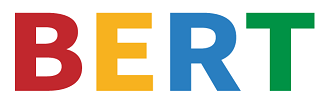

In [ ]:
def model_fn(encoder, seq_len=256):
    #tensorflow.keras.layers as L
    input_ids = L.Input(shape=(seq_len,), dtype=tf.int32, name='input_ids')
    input_attention_mask = L.Input(shape=(seq_len,), dtype=tf.int32, name='attention_mask')
    
    outputs = encoder({'input_ids': input_ids, 
                       'attention_mask': input_attention_mask})
    
    model = Model(inputs=[input_ids, input_attention_mask], outputs=outputs) #inputは2つでいいのか。

    optimizer = optimizers.Adam(lr=LEARNING_RATE)
    model.compile(optimizer=optimizer, 
                  loss=losses.MeanSquaredError(),  #平均二乗誤差
                  metrics=[metrics.RootMeanSquaredError()]) #y_trueとy_predの間の二乗平均平方根誤差メトリックを計算します。
    
    return model


with strategy.scope():  
    encoder = TFAutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)
    model = model_fn(encoder, SEQ_LEN) #bertモデルを作っている。
    
model.summary()

# Training

BASE_MODELは学習済モデル。<br>
マスクされた言語モデリング (MLM) の目的を使用した英語の事前トレーニング済みモデル。 このホワイトペーパーで紹介され、このリポジトリで最初にリリースされました。 このモデルは大文字と小文字を区別します。
RoBERTa をリリースするチームはこのモデルのモデルカードを作成しなかったため、このモデルカードは Hugging Face チームによって作成されましたとあります。<br>

TPUで実行すると、2回目のfoldでKeyError: 'logits'　となってこける。なんでかわかんない。GPUで動かすしかないようです。

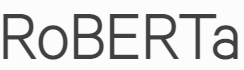

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; history_list = []; test_pred = []

for fold,(idxT, idxV) in enumerate(skf.split(train)):
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {len(idxT)} VALID: {len(idxV)}')

    #import tensorflow.keras.backend as K
    K.clear_session()
    with strategy.scope():
        encoder = TFAutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1) #TFAutoModelForSequenceClassificationは、不明だがencoderにしている
        model = model_fn(encoder, SEQ_LEN)

#謎です。
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
#from transformers import TFAutoModelForSequenceClassification, TFAutoModel, AutoTokenize

    model_path = f'model_{fold}.h5'
    es = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', 
                       patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_root_mean_squared_error', mode='min', 
                                 save_best_only=True, save_weights_only=True)

    # Train
    history = model.fit(x=get_dataset(train.loc[idxT], tokenizer, repeated=True, is_sampled=True, #get_datasetを呼んでいる。その中でexcerptを抽出している。
                                      batch_size=BATCH_SIZE, seq_len=SEQ_LEN), 
                        validation_data=get_dataset(train.loc[idxV], tokenizer, ordered=True, 
                                                    batch_size=BATCH_SIZE, seq_len=SEQ_LEN), 
                        steps_per_epoch=50, 
                        callbacks=[es, checkpoint], 
                        epochs=EPOCHS,  
                        verbose=2).history
      
    history_list.append(history)
    # Save last model weights
    model.load_weights(model_path)
    
    # Results
    print(f"#### FOLD {fold+1} OOF RMSE = {np.min(history['val_root_mean_squared_error']):.4f}")

    # OOF predictions
    valid_ds = get_dataset(train.loc[idxV], tokenizer, ordered=True, batch_size=BATCH_SIZE, seq_len=SEQ_LEN)
    oof_labels.append([target[0].numpy() for sample, target in iter(valid_ds.unbatch())])
    x_oof = valid_ds.map(lambda sample, target: sample)
    oof_pred.append(model.predict(x_oof)['logits']) #predictのoutputのligitsだけを抽出

    # Test predictions
    test_ds = get_dataset(test, tokenizer, labeled=False, ordered=True, batch_size=BATCH_SIZE, seq_len=SEQ_LEN)
    x_test = test_ds.map(lambda sample: sample)
    test_pred.append(model.predict(x_test)['logits'])

# 実験

In [ ]:
TFAutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1) 

結局、encorderに何をいれているのかよくわからないが、All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.が答えかな。

In [ ]:
get_dataset(train.loc[idxT], tokenizer, repeated=True, is_sampled=True, #
                                      batch_size=BATCH_SIZE, seq_len=SEQ_LEN),

ここで普通はx,yを渡して学習させているはずなんですけど。ここが解ければわかるはず。

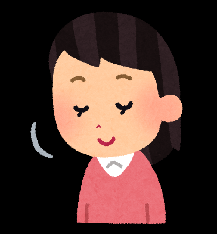

In [ ]:
get_dataset(train.loc[idxV], tokenizer, ordered=True, 
                                                    batch_size=BATCH_SIZE, seq_len=SEQ_LEN)

In [ ]:
model.predict(x_oof)[0][0]

In [ ]:
x_oof #valid_ds.map(lambda sample, target: sample)

In [ ]:
test_ds

## モデルの損失とメトリックのグラフ

In [ ]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history)

OOF 予測でモデルを評価しています。これは Out Of Fold を表しています。K-Fold を使用してトレーニングしているため、モデルはすべてのデータを表示しています。

In [ ]:
y_true = np.concatenate(oof_labels)
y_preds = np.concatenate(oof_pred)


for fold, history in enumerate(history_list):
    print(f"FOLD {fold+1} RMSE: {np.min(history['val_root_mean_squared_error']):.4f}")
    
print(f'OOF RMSE: {mean_squared_error(y_true, y_preds, squared=False):.4f}')

### **Error analysis**, label x prediction distribution

ここで、ラベルからの分布と予測値を比較しています。完全なシナリオでは、それらは一致するはず。大体一致しているような。

In [ ]:
preds_df = pd.DataFrame({'Label': y_true, 'Prediction': y_preds[:,0]})

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(preds_df['Label'], ax=ax, label='Label')
sns.distplot(preds_df['Prediction'], ax=ax, label='Prediction')
ax.legend()
plt.show()

In [ ]:
sns.jointplot(data=preds_df, x='Label', y='Prediction', kind='reg', height=10)
plt.show()

# 予測

In [ ]:
submission = test[['id']]
submission['target'] = np.mean(test_pred, axis=0)
submission.to_csv('submission.csv', index=False)
display(submission.head(10))

このコードがわかったころには、コンペが終わっている気がする。

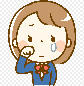